## Dataset: https://archive.ics.uci.edu/dataset/1/abalone

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

import shap
shap.initjs()

In [4]:
data = pd.read_csv('./abalone/abalone.data',
                   names=['sex', 'length', 'diameter', 'height', 'whole weight', 'shucked weight', 'viscera weight', 'shell weight', 'rings']
                   )

In [5]:
print(len(data))
data.head()

4177


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Our aim is to predict age of abalone and more specificly rings column. We can predict rings column based on size and weight

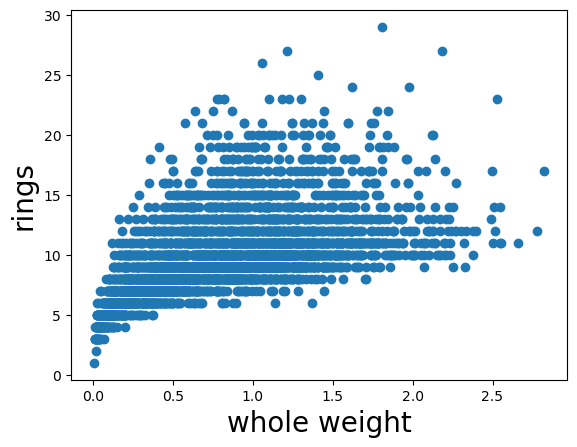

In [6]:
# Plot 1: whole weight
plt.scatter(data['whole weight'], data['rings'])
plt.ylabel('rings', size=20)
plt.xlabel('whole weight', size=20)
plt.show()

Text(0.5, 0, 'sex')

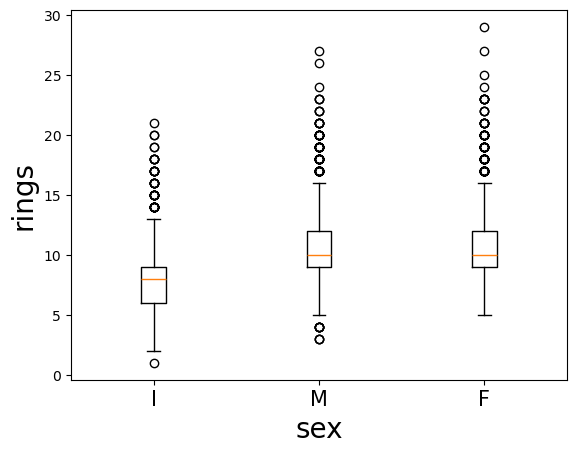

In [9]:
# Plot #2: sex
plt.boxplot(data[data["sex"]=='I']['rings'],positions=[1])
plt.boxplot(data[data["sex"]=='M']['rings'],positions=[2])
plt.boxplot(data[data["sex"]=='F']['rings'],positions=[3])

plt.xticks(ticks=[1,2,3],labels=['I','M','F'], size=15)
plt.ylabel('rings', size=20)
plt.xlabel('sex', size=20)

<Axes: >

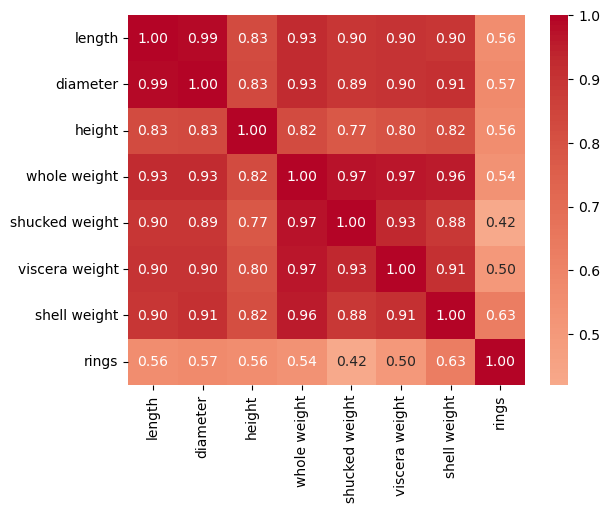

In [12]:
# Plot 3: Correlation heatmap
cont = ["length", "diameter", 'height', 'whole weight', 'shucked weight', 'viscera weight', 'shell weight', 'rings']
corr_matrix = pd.DataFrame(data[cont], columns=cont).corr()

sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center = 0,
            annot=True,
            fmt='.2f')

## Feature Engineering

In [14]:
y = data['rings']
X = data[['sex', 'length', 'height', 'shucked weight', 'viscera weight', 'shell weight']]

In [15]:
# Create dummy variables
X['sex.M'] = [1 if s == 'M' else 0 for s in X['sex']]
X['sex.F'] = [1 if s == 'F' else 0 for s in X['sex']]
X['sex.I'] = [1 if s == 'I' else 0 for s in X['sex']]
X = X.drop('sex', axis=1)

X.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


## Modeling

In [16]:
# Train model
model = xgb.XGBRFRegressor(objective='reg:squarederror')
model.fit(X, y)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

Text(0.5, 0, 'Actual')

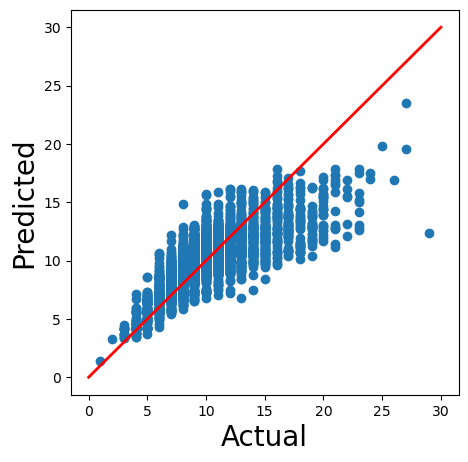

In [17]:
# Get predictions
y_pred = model.predict(X)

# Model evalutation
plt.figure(figsize=(5,5))

plt.scatter(y,y_pred)
plt.plot([0,30],
         [0,30],
         color="r",
         linestyle='-',
         linewidth=2)

plt.ylabel('Predicted', size=20)
plt.xlabel('Actual', size=20)

## SHAP Values

In [18]:
# Standard SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Now we use SHAP how model makes prediction. We're passing model to shap.Explainer function. In case we have a big dataset better to use something like this: shap_values = exaplainer(X[0:100])

In [19]:
np.shape(shap_values.values)

(4177, 8)

### Waterfall plot

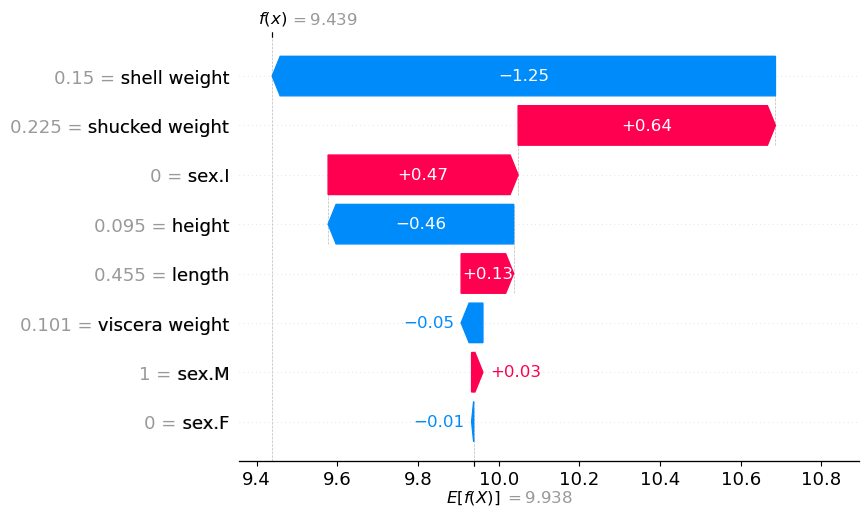

In [20]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In [23]:
# Force plot
shap.plots.force(shap_values[0])

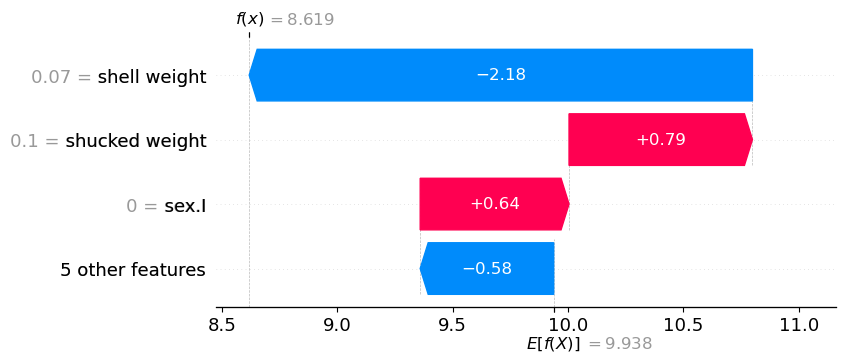

In [21]:
shap.plots.waterfall(shap_values[1], max_display=4)

In [24]:
# Stacked force plot
shap.plots.force(shap_values[0:100])

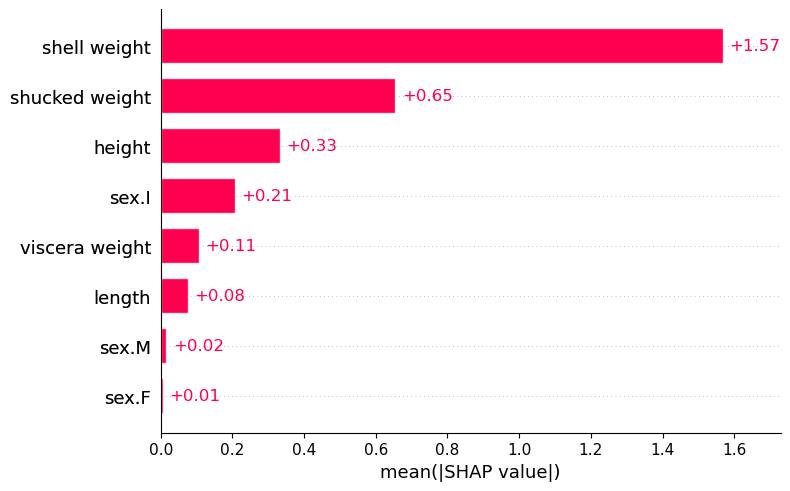

In [25]:
# Let's explore which features are most important for the model
# Absolute Mean SHAP
shap.plots.bar(shap_values)

## Beeswarm plot

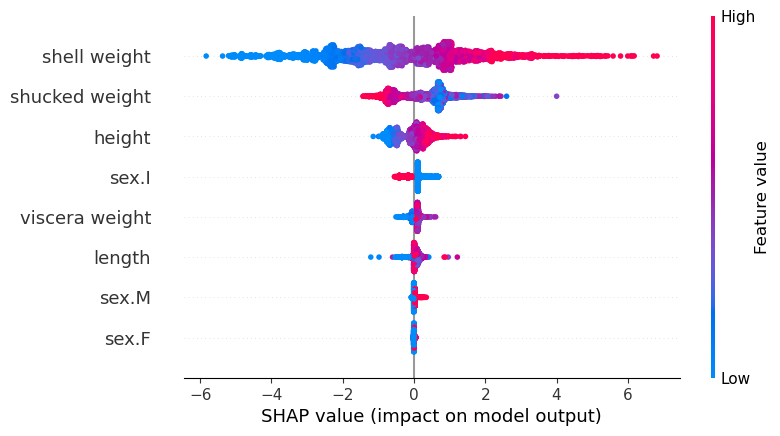

In [26]:
shap.plots.beeswarm(shap_values)

# Dependence plot

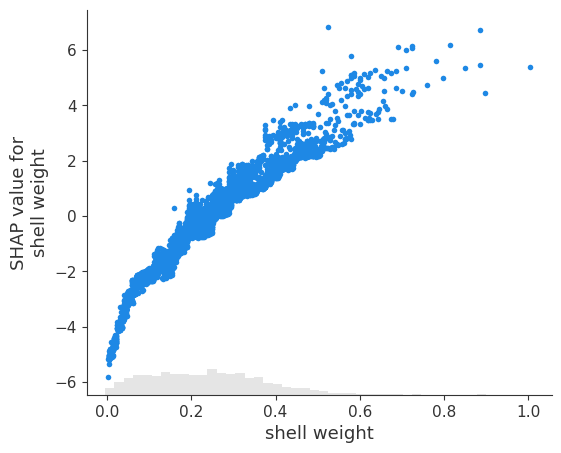

In [27]:
# Plot 1: shell weight
shap.plots.scatter(shap_values[:,"shell weight"])

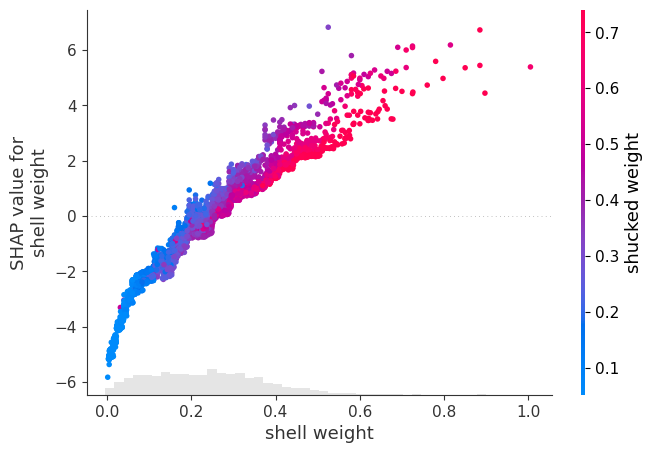

In [28]:
shap.plots.scatter(shap_values[:,"shell weight"],
                   color=shap_values[:,"shucked weight"])

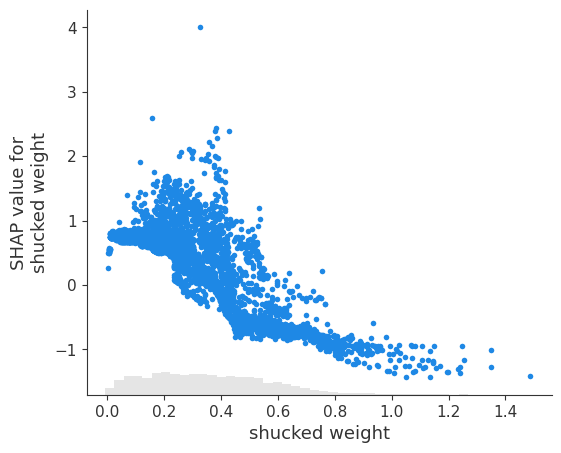

In [29]:
# Plot 2: shucked weight
shap.plots.scatter(shap_values[:,"shucked weight"])